### Imports and Prelims

In [91]:
import numpy as np 
import sympy as sy 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from positionedpogos.math import (calculate_jacobian_symmetric_difference,
calculate_jacobian_forward_difference, calculate_jacobian_backward_difference)

%matplotlib inline 

### Defining RR Arm Symbolically

In [2]:
# First define arm lengths 
La, Lb = sy.symbols('La Lb') 

# Symbolic variables 
theta_1, theta_2 = sy.symbols('theta_1 theta_2') 

# Forward function 
f = sy.Matrix([
    La*sy.cos(theta_1) + Lb*sy.cos(theta_2), 
    La*sy.sin(theta_1) + Lb*sy.sin(theta_2)
])

J = f.jacobian([theta_1, theta_2]) 

In [3]:
f

Matrix([
[La*cos(theta_1) + Lb*cos(theta_2)],
[La*sin(theta_1) + Lb*sin(theta_2)]])

In [4]:
J

Matrix([
[-La*sin(theta_1), -Lb*sin(theta_2)],
[ La*cos(theta_1),  Lb*cos(theta_2)]])

### Substitute Values for Arm Lengths for Experiments

In [7]:
La_val = 0.5
Lb_val = 0.3

f_numeric = f.subs([(La, La_val), (Lb, Lb_val)])
J_numeric = J.subs([(La, La_val), (Lb, Lb_val)])

In [8]:
f_numeric

Matrix([
[0.5*cos(theta_1) + 0.3*cos(theta_2)],
[0.5*sin(theta_1) + 0.3*sin(theta_2)]])

In [10]:
J_numeric

Matrix([
[-0.5*sin(theta_1), -0.3*sin(theta_2)],
[ 0.5*cos(theta_1),  0.3*cos(theta_2)]])

### Convert to Numpy Functions

In [13]:
f_functional = sy.lambdify([theta_1, theta_2], f_numeric, 'numpy')
J_functional = sy.lambdify([theta_1, theta_2], J_numeric, 'numpy') 

In [20]:
f_result = f_functional(1, 2)
print(f_result) 
print(type(f_result))

[[0.1453071 ]
 [0.69352472]]
<class 'numpy.ndarray'>


In [60]:
def f_functional_numpy(theta): 
    return np.reshape(f_functional(*theta), (2,))

def J_functional_numpy(theta): 
    return J_functional(*theta) 


In [61]:
a = np.array([1, 2]) 
print("f_functional_numpy")
print(f_functional_numpy(a))
print("J_functional_numpy") 
print(J_functional_numpy(a))

f_functional_numpy
[0.1453071  0.69352472]
J_functional_numpy
[[-0.42073549 -0.27278923]
 [ 0.27015115 -0.12484405]]


### Perform Experiment on Default h Value

In [62]:
# Get random samples 
num_samples = 1000
samples = np.random.uniform(0, -2*np.pi, (num_samples, 2)) 

Text(0.5, 1.0, 'Distribution of variables across random samples')

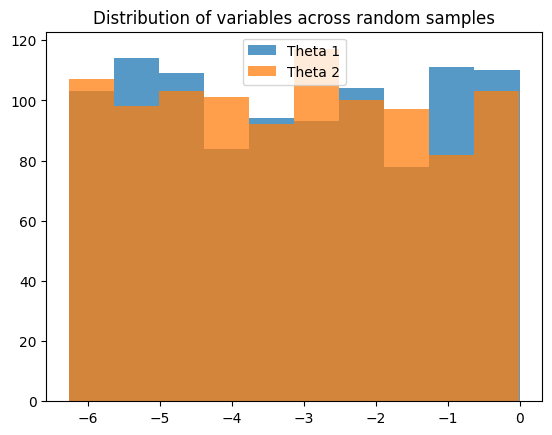

In [70]:
counts, bins = np.histogram(samples[:, 0])
counts2, bins2 = np.histogram(samples[:, 1])
    
plt.hist(bins[:-1], bins, weights=counts, alpha=0.75)
plt.hist(bins2[:-1], bins2, weights=counts2, alpha=0.75)
plt.legend(["Theta 1", "Theta 2"]) 
plt.title("Distribution of variables across random samples") 

Now that we have our samples, we are going to perform 4 methods of calculating the Jacobian. We are going to use the analytical method, given by `J_functional_numpy` and then we are going to call each of our jacobian functions on the data. We are going to compare norm error for all trials

In [64]:
J_computed_analytical = np.zeros((num_samples, 2, 2))
J_computed_forward = np.zeros((num_samples, 2, 2))
J_computed_backward = np.zeros((num_samples, 2, 2)) 
J_computed_symmetric = np.zeros((num_samples, 2, 2))

for i in tqdm(range(num_samples)): 
    current_point = samples[i, :]

    J_computed_analytical[i, :, :] = J_functional_numpy(current_point) 
    J_computed_forward[i, :, :] = calculate_jacobian_forward_difference(f_functional_numpy, current_point)
    J_computed_backward[i, :, :] = calculate_jacobian_backward_difference(f_functional_numpy, current_point)
    J_computed_symmetric[i, :, :] = calculate_jacobian_symmetric_difference(f_functional_numpy, current_point)

  0%|          | 0/1000 [00:00<?, ?it/s]

Now let's calculate the error for each of the computed methods. We can get the error for each, and plot everything on a histogram, with respect to the analytical solution. Let's do L1 and L2 loss. 

In [72]:
J_forward_errors = np.zeros((num_samples, 6))
J_backward_errors = np.zeros((num_samples, 6))
J_symmetric_errors = np.zeros((num_samples, 6))

for i in tqdm(range(num_samples)): 
    current_truth = J_computed_analytical[i, :, :].reshape((4,))
    diff_forward = J_computed_forward[i, :, :].reshape((4,)) - current_truth
    diff_backward = J_computed_backward[i, :, :].reshape((4,)) - current_truth
    diff_symmetric = J_computed_symmetric[i, :, :].reshape((4,)) - current_truth

    # Then calculate errors 
    J_forward_errors[i, :] = np.concatenate((np.array([np.linalg.norm(diff_forward, ord=1), np.linalg.norm(diff_forward, ord=2)]), diff_forward))
    J_backward_errors[i, :] = np.concatenate((np.array([np.linalg.norm(diff_forward, ord=1), np.linalg.norm(diff_forward, ord=2)]), diff_backward))
    J_symmetric_errors[i, :] = np.concatenate((np.array([np.linalg.norm(diff_forward, ord=1), np.linalg.norm(diff_forward, ord=2)]), diff_symmetric))

  0%|          | 0/1000 [00:00<?, ?it/s]

Now we can plot some statistics and results. Let's start with the mean/variance of our errors for each approach

In [82]:
methods = ['Forward Difference', 'Backward Difference', 'Symmetric Difference']
method_errors = [J_forward_errors, J_backward_errors, J_symmetric_errors]

print(f"Statistics Table for Errors of Each Jacobian Calculation Method") 
for i, error in enumerate(method_errors):
    means = np.mean(error, axis=0)
    stds = np.std(error, axis=0)
    print(f"Method: {methods[i]}") 
    print(f"------ L2 ------") 
    print(f" Mean: {means[0]}") 
    print(f" STD: {stds[0]}") 
    print(f"------ L2 ------") 
    print(f" Mean: {means[1]}") 
    print(f" STD: {stds[1]}") 
    print(f"-- Per Elem. ---") 
    for j in range(4): 
        print(f" E{j+1}: ({means[j + 2]}/{stds[j + 2]})")
    print(f"----------------\n")

Statistics Table for Errors of Each Jacobian Calculation Method
Method: Forward Difference
------ L2 ------
 Mean: 5.1034349041990685e-06
 STD: 3.574896984975363e-07
------ L2 ------
 Mean: 2.9154757567823755e-06
 STD: 4.500428441102383e-12
-- Per Elem. ---
 E1: (-1.306099729916399e-07/1.7713612205005107e-06)
 E2: (2.234836531785501e-08/1.0688673477917307e-06)
 E3: (-3.515024791315643e-08/1.7589724084706296e-06)
 E4: (-1.627407063417314e-08/1.0520257478769459e-06)
----------------

Method: Backward Difference
------ L2 ------
 Mean: 5.1034349041990685e-06
 STD: 3.574896984975363e-07
------ L2 ------
 Mean: 2.9154757567823755e-06
 STD: 4.500428441102383e-12
-- Per Elem. ---
 E1: (1.3062156757425836e-07/1.7713634245316436e-06)
 E2: (-2.234164470808341e-08/1.0688690541147768e-06)
 E3: (3.5142202072530746e-08/1.758969490675806e-06)
 E4: (1.6270218851341214e-08/1.052024262502681e-06)
----------------

Method: Symmetric Difference
------ L2 ------
 Mean: 5.1034349041990685e-06
 STD: 3.574896

All seem to be relatively reliable in this approach! Now let's show histograms just to be sure. Let's first start with norms, and then we can go to per-element

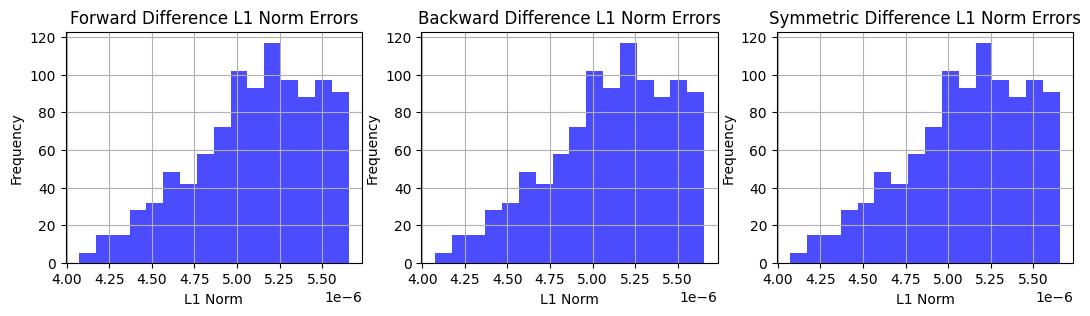

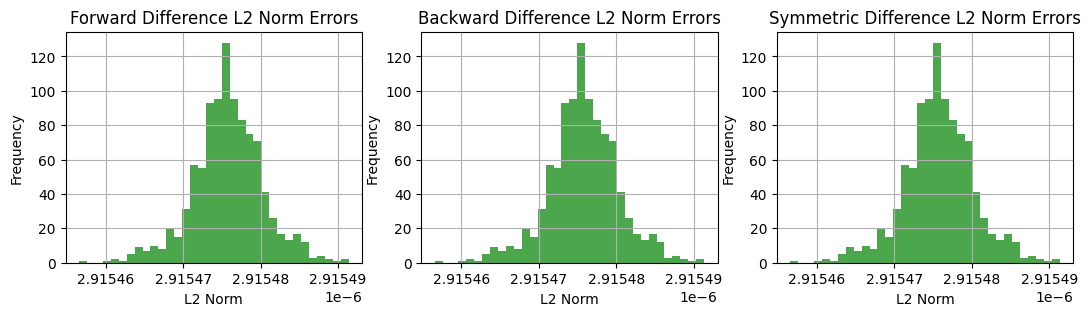

In [93]:
# Creating figures and axes for L1 and L2 histograms
num_methods = len(methods) 
fig_l1, axes_l1 = plt.subplots(1, num_methods, figsize=(13, 3))
fig_l2, axes_l2 = plt.subplots(1, num_methods, figsize=(13, 3))

for i, errors in enumerate(method_errors):
    # Extract L1 and L2 norms
    l1_norms = errors[:, 0]
    l2_norms = errors[:, 1]

    # Plot L1 histogram
    axes_l1[i].hist(l1_norms, bins='auto', color='blue', alpha=0.7)
    axes_l1[i].set_title(f'{methods[i]} L1 Norm Errors')
    axes_l1[i].set_xlabel('L1 Norm')
    axes_l1[i].set_ylabel('Frequency')
    axes_l1[i].grid(True)

    # Plot L2 histogram
    axes_l2[i].hist(l2_norms, bins='auto', color='green', alpha=0.7)
    axes_l2[i].set_title(f'{methods[i]} L2 Norm Errors')
    axes_l2[i].set_xlabel('L2 Norm')
    axes_l2[i].set_ylabel('Frequency')
    axes_l2[i].grid(True)

for ax in axes_l1:
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter(useOffset=False))

for ax in axes_l2:
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter(useOffset=False))


plt.show()

Now we can show the per-element error for each method. 

Text(0.5, 0.98, 'Per-Element Error Histograms For All Methods')

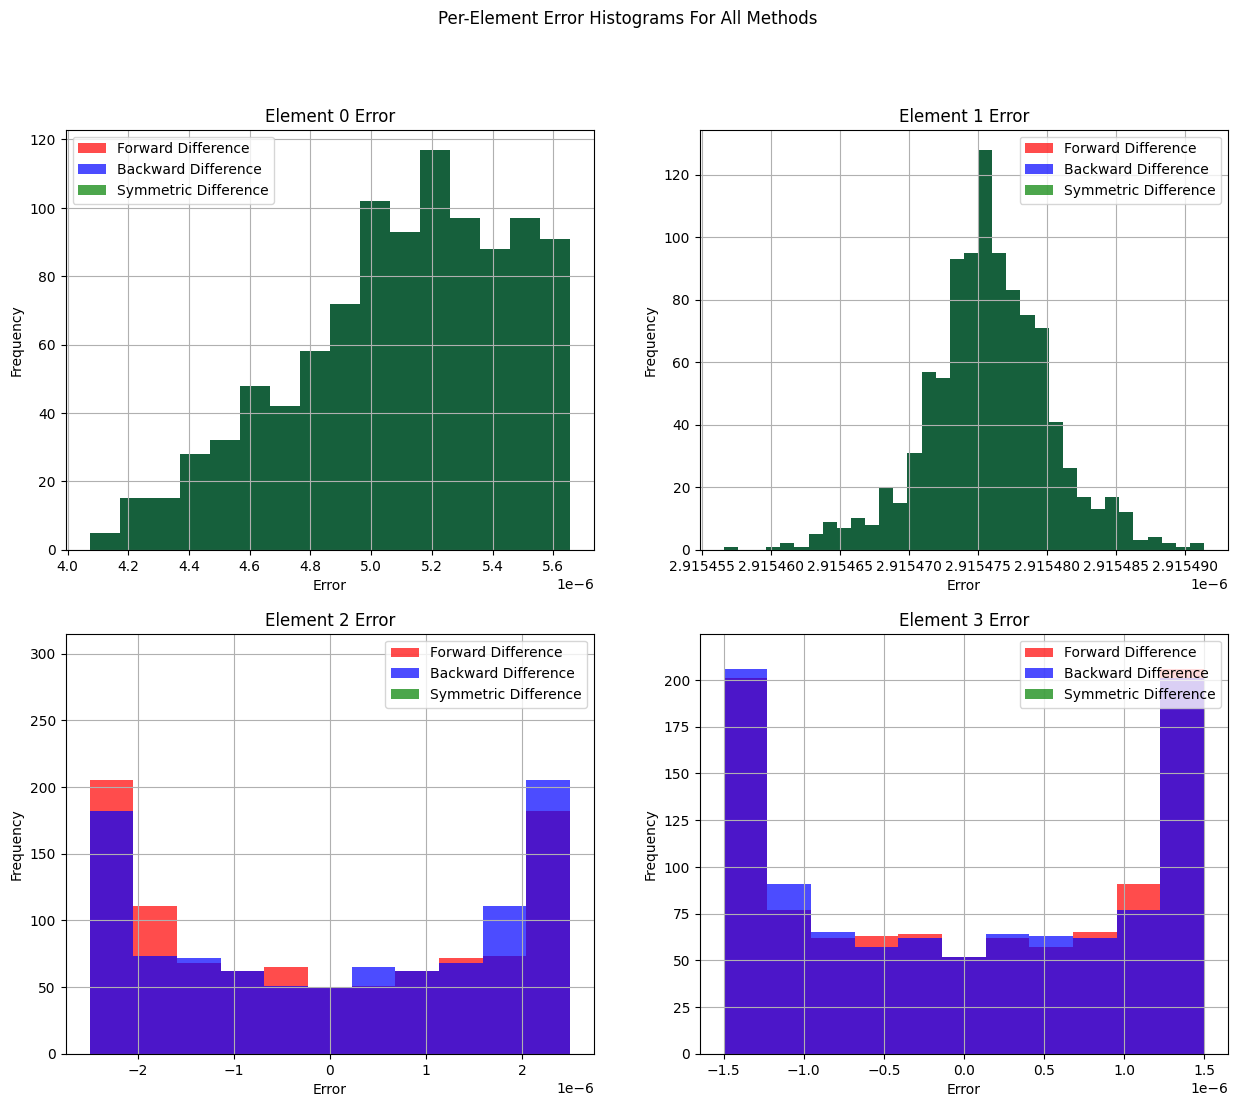

In [101]:
num_elements = 4
fig_elems, axis_elems = plt.subplots(2, 2, figsize=(15, 12))
methods_colors = ['red', 'blue', 'green']

for i, errors, in enumerate(method_errors): 
    # Extract elementwise errors
    for j in range(num_elements): 
        axis_elems.flat[j].hist(errors[:, j], bins='auto', alpha=0.7, color=methods_colors[i], label=methods[i])
        axis_elems.flat[j].set_title(f"Element {j} Error")
        axis_elems.flat[j].set_xlabel("Error") 
        axis_elems.flat[j].set_ylabel("Frequency")
        axis_elems.flat[j].grid(True)

for ax in axis_elems.flat:
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    ax.legend()

fig_elems.suptitle("Per-Element Error Histograms For All Methods") 